PROGRAMACIÓN DE LA LÓGICA PROGRAMABLE E IMPORTACIÓN DE LAS LIBRERÍAS

In [ ]:
from pynq import Overlay
base = Overlay("/home/xilinx/jupyter_notebooks/MisCosas/Config/ReguladorEnFPGA.bit")

from pynq.lib import AxiGPIO

import matplotlib.pyplot as plt
import time

DECLARACIÓN DE CONSTANTES

In [7]:
Nbits=31
ParteEntera=24
Ts=5e-3
Tiempo=5
Escalon=15

FUNCIONES PARA EL TRATAMIENTO DE LOS NÚMEROS

In [2]:
def ToBinary(IN):
    B=[]
    while(IN>1):
        B.append(IN%2)
        IN=IN//2
    B.append(IN)
        
    while(len(B)<Nbits):
        B.append(0)
        
    return B

In [3]:
def ToDecimalBinary(IN):
    B=[]
    for i in range(0, ParteEntera):
        PM=IN-2**(-i-1)
        if(PM>=0): 
            B.append(1)
            IN=PM
        else: B.append(0)
            
    return B

In [4]:
def InvertBinary(IN):
    B=[]
    for i in range(len(IN)-1, -1, -1):
        B.append(IN[i])
        
    return B

In [5]:
def ToDecimalEntero(IN):
    DE=0
    for i in range(len(IN)-1, -1, -1):
        DE+=(2**i)*IN[i]
        
    return DE

In [6]:
def ToDecimalFraccional(IN):
    DF=0
    for i in range(len(IN)-1, -1, -1):
        DF+=(2**(-i-1))*IN[i]
        
    return DF

ACCESO A LOS BLOQUES AXI GPIO

In [ ]:
AXIGPIO0=base.ip_dict['axi_gpio_0']
CV_ENT=AxiGPIO(AXIGPIO0).channel1
CV_S=AxiGPIO(AXIGPIO0).channel2

AxiGPIO1=base.ip_dict['axi_gpio_1']
ERROR_ENT=AxiGPIO(AxiGPIO1).channel1
ERROR_S=AxiGPIO(AxiGPIO1).channel2

# PROGRAMA

Simulación

In [38]:
#Se inicializa con un error de 0.
ERROR_ENT[0:32].write(0)
ERROR_S[0:1].write(0)
i=0

#Se inicializa la lista t en la que se guardarán los tiempos.
t=[]
while(i<Tiempo):
    t.append(i)
    i+=Ts
    
i=0

In [40]:
time.sleep(10)

Inicio=0.3
Input, y, z=[], [], []

while(i<Inicio):
    Input.append(0)
    y.append(CV_ENT.read())
    z.append(CV_S.read())
    i+=Ts
    time.sleep(Ts)
    
BE=InvertBinary(ToBinary(int(Escalon//1))[0:Nbits-ParteEntera])+ToDecimalBinary(Escalon-Escalon//1)
ERROR_ENT[0:32].write(ToDecimalEntero(InvertBinary(BE)))

while(i<Tiempo):
    Input.append(Escalon)
    y.append(CV_ENT.read())
    z.append(CV_S.read())
    Escalon=15-4*(i-0.3)
    if(Escalon<0):
        Escalon=0
    BE=InvertBinary(ToBinary(int(Escalon//1))[0:Nbits-ParteEntera])+ToDecimalBinary(Escalon-Escalon//1)
    ERROR_ENT[0:32].write(ToDecimalEntero(InvertBinary(BE)))
    i+=Ts
    time.sleep(Ts)

Output=y

GRÁFICA

In [36]:
Output=[]
for i in range(len(y)):
    #Pasamos a binario la lectura de la FPGA.
    S=ToBinary(y[i])
    #Para la parte entera eliminamos los bits decimales, del 0 hasta el 23.
    #Para la parte decimal eliminamos los bits enteros, del 24 hasta el 31.
    Output.append(z[i]*127+ToDecimalEntero(S[ParteEntera:Nbits])+ToDecimalFraccional(InvertBinary(S[0:ParteEntera])))

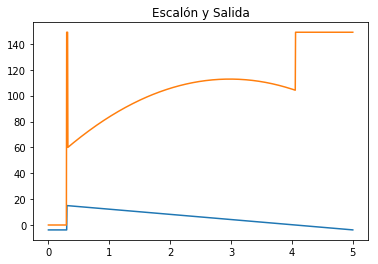

In [37]:
fig, P1= plt.subplots() 
P1.plot(t, Input, t, Output)
P1.set_title('Escalón y Salida');